In [4]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.qmc import LatinHypercube

In [5]:
# Own implementations
%load_ext autoreload
%autoreload 2
from pinn import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Double-precision by default
torch.set_default_dtype(torch.float64)

In [7]:
def rejection_sampling(pdf, n=1000, xmin=0, xmax=.98):
    x=torch.linspace(xmin,xmax,1000)  
    y=pdf(x)  
    pmin=0.  
    pmax=y.max()  
   
    naccept=0  
   
    ran=[] # output list of random numbers  
    while naccept<n:  
        x = (xmax - xmin) * torch.rand(1) + xmin  
        y = (pmax - pmin) * torch.rand(1) + pmin   
        
        if y<pdf(x):  
            ran.append(x)  
            naccept=naccept+1  
    
    return np.asarray(ran)  

def generate_random_symmetric_matrix(dim):
    M_random = torch.rand((dim,dim)) - 0.5
    return 0.5 * (M_random.T + M_random)

def eigenvalue_of_eigenvector(x):
    return ((x @ A @ x.T) / (x @ x.T)).item()

In [8]:
## ODE specification

In [9]:
# Eigenvalue Problem
#A = generate_random_symmetric_matrix(dim)
A = torch.tensor(1/4 * np.array([[1,2,3,4,5],[2,-1,-2,-3,-4],[3,-2,1,1,1],[4,-3,1,0,0],[5,-4,1,0,0]]))
dim = A.shape[-1]
print(f"A = {A}")

def f(y):
    first_term = (y[:,None,:] @ (y[:,None,:] @ y[:,:,None] * A)).squeeze()
    second_term = (y[:,None,:] @ A @ y[:,:,None] @ y[:,None,:]).squeeze()
    return first_term - second_term

# Coordinate Transformations to bring to infinite time domain t \in [0,inf) to tau \in [0,1)
def dtau_dt_inv_tan(tau):
    """
    Assuming t = tan(pi/2 * tau) this is (dtau/dt)^(-1)
    """
    return torch.pi/(2 * torch.cos(torch.pi/2 * tau)**2)

def dtau_dt_inv_arctanh(tau):
    """
    Assuming t = arctanh(tau) this is (dtau/dt)^(-1)
    """
    return 1.0/(1.0 - tau**2)

# Random intial vector as initial condition. Function attributes used to fix the random vector across calls
def ic(y, tau):
    return y - ic.y0, torch.zeros_like(y)
ic.y0 = torch.rand(dim).reshape(1,-1)
ic.y0 /= torch.sqrt(ic.y0 @ ic.y0.T).item()

# We can interpret the conservation property of the ODE as boundary condition. Note that we compare against a scalar property 
# (the norm) and not a vector. Hence the difference in the second return argument compared to ic() or eigenvector_ode()
def norm_conservation(y, tau):
    return (y[:,None,:] @ y[:,:,None]).squeeze(-1), torch.ones_like(tau)

def eigenvector_ode(y, tau):    
    dtau_dt_inv = dtau_dt_inv_tan(tau)
    y_tau = derivative(y, tau)
    return y_tau - dtau_dt_inv * f(y), torch.zeros_like(y)
eigenvector_ode.domain_dim=1
eigenvector_ode.target_dim=dim
    
def temporal_sample(N_t, kind="lhs", function=dtau_dt_inv_tan):
    if kind == "lhs":
        sampler = lambda N: torch.from_numpy(LatinHypercube(1).random(n = N))
    elif kind == "uniform":
        sampler = lambda N: torch.from_numpy(np.linspace(0.01, .99, N).reshape(-1,1))
    elif kind == "rejection":
        sampler = lambda N: rejection_sampling(function, n=N, xmin=0.01, xmax=0.99).reshape(-1,1)
    
    #Interior points
    samples_t = sampler(N_t)
    
    # Initial condition
    samples_t_ic = torch.tensor([0.]).reshape(-1,1)
    
    return samples_t, \
           samples_t_ic, \
           samples_t

A = tensor([[ 0.2500,  0.5000,  0.7500,  1.0000,  1.2500],
        [ 0.5000, -0.2500, -0.5000, -0.7500, -1.0000],
        [ 0.7500, -0.5000,  0.2500,  0.2500,  0.2500],
        [ 1.0000, -0.7500,  0.2500,  0.0000,  0.0000],
        [ 1.2500, -1.0000,  0.2500,  0.0000,  0.0000]])


torch.Size([512, 1]) torch.Size([1, 1]) torch.Size([512, 1])


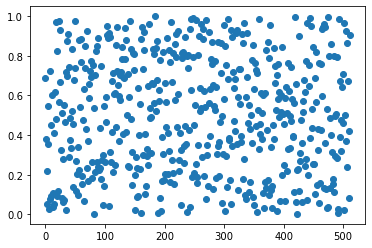

In [10]:
#IBVP parameters
N_interior =  2**9

# Generate training set
X_train = temporal_sample(N_interior, kind="lhs")
t_int, t_ic, t_bc = X_train
print(t_int.shape, t_ic.shape, t_bc.shape)

# Generate test data
X_test = temporal_sample(N_interior, kind="lhs")

plt.scatter(np.arange(N_interior), t_int)
plt.show()

In [20]:
eigen_nn = PiNN(eigenvector_ode, ic, norm_conservation, verbose=True)
eigen_nn.fit(X_train, None)

---------------------------Hyperparameters----------------------------
# of collocation points per batch:                                 512
# of boundary points per batch:                                    512
# of initial condition points per batch:                             1
# of minbatches:                                                     1
Points per Iteration:                                           262144
Iterations:                                                        100
Total number of collocation points                            26214400
----------------------------------------------------------------------
  Epoch   |  Total Loss   |  Loss (PDE)   |   Loss (BC)   |   Loss (IC)   
    0     |   1.356016e+00|   4.857086e-03|   9.895387e-01|   1.808099e-01
    10    |   1.274021e+00|   1.150603e-02|   9.736927e-01|   1.444110e-01
    20    |   9.358558e-01|   1.152560e-01|   7.560748e-01|   3.226248e-02
    30    |   9.155594e-01|   1.763772e-01|   6.977236e-01|  

In [77]:
def eigendecomposition(A, verbose=True):
    
    # Coordinate Transformations
    def dtau_dt_inv_tan(tau):
        """
        Assuming t = tan(pi/2 * tau) this is (dtau/dt)^(-1)
        """
        return torch.pi/(2 * torch.cos(torch.pi/2 * tau)**2)

    def dtau_dt_inv_arctanh(tau):
        """
        Assuming t = arctanh(tau) this is (dtau/dt)^(-1)
        """
        return 1.0/(1.0 - tau**2)
    
    dim = A.shape[0]
    
    #Initial Condition
    y_0 = torch.rand(dim).reshape(1,dim)
    y_0 /= torch.sqrt(y_0 @ y_0.T).item()
    y_0 = y_0.reshape(1,-1)
    
    # Hyperparameters for model and learning
    hidden_layers = [200,200]
    batchsize= 2**9
    number_of_minibatches=1
    epochs = 2000
    
    # Hyperparameters for the dataset
    fixed_dataset = False
    kind = "lhs"
    sampler = LatinHypercube(1)
    
    if fixed_dataset:
        if kind == "rejection":
            samples = rejection_sampling(dtau_dt_inv_tan, n=batchsize * number_of_minibatches, 
                                         xmin=0.01, xmax=0.99).reshape(-1,1)
        elif kind == "linspace":
            samples = np.linspace(0.01, 0.99, batchsize * number_of_minibatches).reshape(-1,1)
        elif kind == "lhs":
            samples = .98 * sampler.random(n=batchsize) + .01
        
    net = EigenPiNN(dim, hidden_layers)
    
    optimizer = torch.optim.Adam(net.parameters())
    loss_fn = torch.nn.MSELoss()
    
    if verbose:
        mean_loss = 0.0
        report_after_e_epochs = min(epochs, 100)
        eigenvalue_evolution = []
        print(f'{"Hyperparameters":-^60}')
        print(f'{"Network Layers/Nodes:":<40}{hidden_layers}')
        print(f'{"Number of collocation points per batch:":<40}{batchsize:>20}')
        print(f'{"Number of minbatches:":<40}{number_of_minibatches:>20}')
        print(f'{"Points per Iteration:":<40}{batchsize * number_of_minibatches:>20}')
        print(f'{"Points fixed?:":<40}{fixed_dataset:>20}')
        print(f'{"Iterations:":<40}{epochs:>20}')
        print(f'{"Total number of collocation points":<40}{epochs * batchsize * number_of_minibatches:>20}')
        print(f'{"":-^60}')
        print(f'{"Epoch":^30}|{"Mean Loss":^30}')
        
    for e in range(1, epochs+1):
        for minibatch in range(number_of_minibatches):
            
            # Interior
            if fixed_dataset:
                tau_interior = torch.tensor(samples[minibatch*batchsize:(minibatch+1)*batchsize], 
                                            dtype=torch.float32, 
                                            requires_grad=True)
            else:
                if kind == "rejection":
                    tau_interior = torch.tensor(rejection_sampling(dtau_dt_inv_tan, 
                                                                   n=batchsize * number_of_minibatches, 
                                                                   xmin=0.01, xmax=0.99),
                                                dtype=torch.float32, 
                                                requires_grad=True)
                elif kind == "linspace":
                    tau_interior = torch.tensor(np.linspace(0.01, 0.99, batchsize), 
                                                dtype=torch.float32, 
                                                requires_grad=True)
                elif kind == "lhs":
                    tau_interior = torch.tensor(.98 * sampler.random(n=batchsize) + .01, 
                                                dtype=torch.float32, 
                                                requires_grad=True)
            tau_interior.reshape(-1,1)
                
            # Forward pass of all interior (collocation) points tau in [0.01, 0.99)
            y_interior = y_0 + tau_interior * net(tau_interior)
            
            dydtau = derivative(y_interior, tau_interior)
            
            dtau_dt_inv = dtau_dt_inv_tan(tau_interior)
            #dtau_dt_inv = dtau_dt_inv_arctanh(tau_interior)
            
            pred_interior, target_interior = dydtau - dtau_dt_inv * f(y_interior, A), torch.zeros_like(dydtau)
            mse_interior = loss_fn(pred_interior, target_interior)
            
            # Norm conservation
            norm_along_trajectory = (y_interior[:,None,:] @ y_interior[:,:,None]).squeeze()
            pred_norm, target_norm = norm_along_trajectory, torch.ones_like(norm_along_trajectory)
            mse_norm = loss_fn(pred_norm, target_norm)
            
            # Boundary
            tau_boundaries = torch.tensor([1.]).reshape(1,1)
            
            # Forward pass of tau=1
            y_boundary = y_0 + tau_boundaries * net(tau_boundaries)
    
            # See Theorem 1
            fy_1_model = f(y_boundary[-1,:].reshape(1,-1), A).reshape(1,-1)
                  
            pred_boundary, target_boundary = fy_1_model, torch.zeros((1,dim), dtype=A.dtype)
            mse_boundary = loss_fn(pred_boundary, target_boundary)

            
            #Total Loss
            loss = mse_interior + mse_boundary + mse_norm
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                mean_loss = mean_loss + loss.item()/report_after_e_epochs
            
        with torch.autograd.no_grad():
            if verbose and e % report_after_e_epochs == 0 and e > 1:
                tau_boundaries = torch.tensor([1.]).reshape(1,1)
                y_boundary = net(tau_boundaries)
                eigenvalue_evolution.append(eigenvalue_of_eigenvector(y_boundary[-1,:].reshape(1,-1)))
                print(f'{e:^30}|{mean_loss:>29.6e}|norm = {torch.dot(y_boundary[-1,:],y_boundary[-1,:])}')
                mean_loss = 0.0
    
    if verbose:
        print(f'{"Iteration limit reached":-^60}')
        return net, eigenvalue_evolution
    else:
        return y_1_model, eigenvalue_of_eigenvector(y_boundary[-1,:])

In [12]:
# Eigenvalue Problem

#Ground Truth
eigenvalues, eigenvectors = np.linalg.eig(A)

# Sort in descending order
permutation = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[permutation]
eigenvectors = eigenvectors[permutation]
print(f"max{{ Sp(A) }} = {np.max(eigenvalues)}")
print(eigenvectors)

max{ Sp(A) } = 2.2536651627025712
[[-0.5393615   0.28132373  0.78915899  0.01174785  0.08388205]
 [-0.17392092 -0.40364478 -0.05408082 -0.40341278  0.80072205]
 [-0.38102841 -0.40079176 -0.04650102 -0.59083212 -0.5856094 ]
 [-0.49519904 -0.49759742 -0.16907792  0.69146749 -0.02144955]
 [ 0.53706233 -0.59134644  0.58613451  0.09955014 -0.0917036 ]]


In [15]:
x = eigen_nn.predict(torch.tensor([1.]).reshape(1,1))
print(f"network = {eigenvalue_of_eigenvector(x)}")

network = -0.0778081910205128


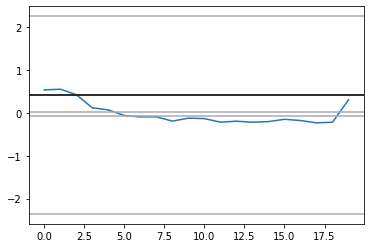

In [80]:
ev_nn = eigenvalue_evolution[-1]
closest_true_ev = eigenvalues[(np.abs(eigenvalues - ev_nn)).argmin()]
plt.plot(eigenvalue_evolution)
for ev in eigenvalues:
    plt.axhline(y=ev, color="darkgray")
    
plt.axhline(y=closest_true_ev, color="k")
plt.show()

In [4]:
torch.arange(4) - 1

tensor([-1,  0,  1,  2])

In [56]:
print(ic(2 * torch.ones(1,dim), None))
print(ic.y0 @ ic.y0.T)

tensor([[1.4616, 1.4830, 1.6461, 1.7215, 1.5362, 1.8419]])
tensor([[1.0000]])
